# Single Query Benchmarks

This notebook includes benchmarks of distance calculations for different data structures  particularly cell-list and KDtree. More specifcally, it lists the time for building the data structure and accessing single point query time for each structure. Respective comparison with expected theoretical runtimes are also included.    

Different sources are used to access the mentioned data structues. Cellgrid package utilizes the cell-list data structure but with grid size equivalent to the cutoff distance search. Another wrapper around Cellgrid is proposed, which have independent cellsize and cutoff-distance as its parameter. Periodic KDTree data structure is already implemented in MDAnalysis, which is most often used for pair searches and near neighbour selection. Brute force method is also implemented in MDAnalysis under distances module.  

The notebook is arranged in the following way:
* Class and function definition for Cell List.
* Methods for build and query time for each data structure
* Tests
* Variation of build time with constant density
* Variation of build Time with increase in number of points (i.e. increasing density)
* Variation of query time with different search radius

This is one of the elementary operation for neighbour search, and therefore selected for benchmarking distance calculations. 

In [35]:
import numpy as np
from MDAnalysis.lib import distances
from collections import defaultdict
from MDAnalysis.lib.pkdtree import PeriodicKDTree
from tqdm import tqdm_notebook
import itertools
import cellgrid

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

# Initialization Data

In [37]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

def _check_box(box):
        return box[:3] if box.shape == (6,) else box    

Assuming uniform distribution. The actual distribution will affect the results and time. 

# Data Structure

## Cell-List 

A data structure of [Cell-List](https://gist.github.com/kain88-de/5002b18630e89c8ce839c2841ebe441d) is utilized here for single point query. Another package [Cellgrid](https://github.com/MDAnalysis/cellgrid/blob/master/cellgrid) also uses CellList data structure, but is not an optimized version for single point query and will be demonstrated further in the notebook. 

In [38]:
class CellList(object):
    """Generate cell list object

    The cell list is stored as a sparse hash-map. Hashes are the 3d coordinates.
    The goal for this implementation is to quickly find neighbors to a single point.
    Using the dict ensures that we only create 'cells' that are actually occupied.
    """
    nei = [-1, 0, 1]
    NEIGHBORS = list(itertools.product(nei, nei, nei))

    def __init__(self, box, coords, cell_size):
        self._box = _check_box(box)
        # pack coords into box
        self._coords = distances.apply_PBC(coords.astype(np.float32), self._box.astype(np.float32))
        self._cell_size = np.ones(3) * cell_size

        self._ncells = (self._box // self._cell_size).astype(int) + 1

        cells = (self._coords // self._cell_size).astype(int)
        cell_map = defaultdict(list)
        for i, cell in enumerate(cells):
            cell_map[tuple(cell)].append(i)
        self._cell_map = cell_map
        
    

    def candidates(self, pos):
        """return all candidate coordinates for pos

        This means all coordinates of the cell in which pos is and all it's
        neighboring cells.

        """
        cell = (pos // self._cell_size).astype(int)
        indices = []
        for neighbor_shift in self.NEIGHBORS:
            neighbor_cell = self._apply_PBC(cell, neighbor_shift)
            indices.extend(self._cell_map[tuple(neighbor_cell)])

        return self._coords[indices]
    
    def search(self, pos, cutoff):
        pos = np.array(pos, dtype=np.float32)
        cand = self.candidates(pos)
        dist = distances.distance_array(pos[np.newaxis, :], cand, box=self._box)[0]
        return cand[dist <= cutoff]
    
    def _apply_PBC(self, cell, shift):
        address = cell + shift
        w = address >= self._ncells
        address[w] -= self._ncells[w]
        w = address < 0
        address[w] += self._ncells[w]
        return address
    
    

Cell-lists are spatial data structures which reduces the computational complexity of the pairwise distance calculations from O(N^2) to O(N) by exploiting the short range interactions of the particles to eliminate unnecessary computation.  Cell-list data structures are intialized by creating a grid of cells followed by asignment of each particle to their respective cell based on its location. This construction, by itself, has a time complexity of O(N) and space complexity of O(kN) where k depends on the grid spacing of cell. Typically, grid size is chosen to be equivalent to the cutoff distance in MD simulations. However, there is a certain memory cost associated with building grids of very low sizes. For non-uniform or skewed data, the performance of cell grid is not optimum as a lot of cells are empty but still a significant amount of execution time is consumed for these dead spaces. It is anticipated that that a relatively larger grid sizes can be used to reduce the construction cost at the expense of more distance evaluations.([1](https://arxiv.org/abs/1412.3784),[2](https://en.wikipedia.org/wiki/Fixed-radius_near_neighbors)). 


A single point query requires brute force distance calculation between the query point and all the particles in the neighbouring cells. For this algorithm, the worst performing case is when all the particles are clustered in a single cell which scales as O(N), whereas the best performance is achieved for uniform distribution. The time complexity for best performing case is O(k), where k  depends on the average number of particles in each cell (k is equivalent to N when all the particles are present in the cell of interest). Additionally, it needs to check 27 cells around the parent cell, which adds to the time complexity. Decreasing the cell size also adds up the space complexity as it also varies as O(n_cells^3). It should be mentioned that this is not a rigourous analysis, but an estimate to understand the variation of execution time and space consumption.

## KDtree

[KDTree](https://github.com/MDAnalysis/mdanalysis/blob/develop/package/MDAnalysis/lib/pkdtree.py) constructs a tree data structure using positions of particles. Periodic boundary condition are used such that all the points are centred around the central cell and the data structure is constructed around the central cell. Only the relevant periodic images are queried for the fixed radius neighbour search depending on the axis aligned bounding box. For instance, if a query point is near to the midpoint of one of the face, only one periodic image corresponding to the other face is constructed and queried individually.  This construct increase the query time as compared to non periodic KDtree, but searching relevant images only slows down the search by a small factor. Variation of query time due to periodicity can be seen [here](https://www.google.com/url?q=https%3A%2F%2Fgithub.com%2FMDAnalysis%2Fmdanalysis%2Fpull%2F1692&sa=D&sntz=1&usg=AFQjCNHKtA6_kwS7LlKWDE42of7MOY8a5w) 

In [39]:
def kdtree_build(box, coords):
    pkdt = PeriodicKDTree(box,bucket_size=10)
    pkdt.set_coords(coords)
    return pkdt
def kdtree_query(struct, coords, pos, cutoff):
    struct.search(pos,cutoff)
    return coords[struct.get_indices()]

Usage of bucket list i.e. maximum number of atoms in a leaf node, significantly reduces the cost of KDtree construction as well as query from the data strcuture. Large bucket size results in less number of nodes, which results in fast depth search but slower brute force calculations. A typical value used is around 5-30. Ideally, construction of a KDtree requires recursive division of all the points based on the median of points into two nodes. This operation requires evaluation of median of points which scales linearly with the number of particles, and recursive division till criteria of bucket size requires O(log N) time, where N is the number of nodes. The best case of KDtree, therefore, corresponds to uniform distribution of particles. Under this distribution, the construction will scale as O(N log(N/bucketsize)) and with a memory complexity of O(N).   
A fixed radius query in Kdtree traverses the data structure to find the node of the query point first, finds the nodes within the radius and searches the particles inside them using distance evaluations. For non periodic boundary conditions, the time for fixed radius search scales as O(KlogN) where K is related to number of particles in the radius i.e. constant for uniform density. It should noted that the time complexity becomes evident with increase in number of particles as compared to linear querying time for cell-list data structure[3](http://www.sccg.sk/~samuelcik/dgs/02_en.pdf). Large number of particles in a fixed volume would lead to large number of nodes, and therefore pruning becomes costly which scales as O(log N) as opposed to constant time in cell-list. However, constant cellgrid size leads to large number of particles in a cell. Distances of all the particles in the neighbourhood are evaluated using naive distance calculations, which increases the time consumption due to increase in particles per cell.    

## Cellgrid Package

Cell List implementation in Cellgrid should also be checked for single point query. A cellgrid object is created here with the given number of points. For the query point, its corresponding cell and respective neighbours are identified followed by sorting the distances from all the particles in neighbouring cell. Neighbouring cells, here, also include the parent cell. This module is compared here to check if the implementation of package scale efficiently or has a big overhead for the case of single queries.

In [40]:
from cellgrid.cgmath import (
    inter_distance_array_withpbc,
    inter_index_array,
)
def cellgrid_build(box, coords, cellsize):
    
    cg1 = cellgrid.CellGrid(_check_box(box), cellsize, coords)
    return cg1

def cellgrid_query(struct,pos,cutoff):
    
    cell = (pos/struct._cell_size).astype(int)
    
    ##Array Initialization
    n_tot = 0
    #print(struct[cell].all_neighbours)
    for other_cell in itertools.chain(struct[cell].all_neighbours,[cell]):
        n_tot += len(struct[other_cell]) 
        distances = np.zeros(n_tot, dtype=np.float32)
        pair_indices = np.zeros((n_tot, 2), dtype=np.int)
    
    ##Distance Evaluations
    p = 0 # pointer to array
    indices = []
    for item in itertools.chain(struct[cell].all_neighbours,[cell]):
        other_cell = struct[item]
        length = len(other_cell)
        inter_distance_array_withpbc(pos[np.newaxis,:], other_cell.coordinates, struct._box, distances[p:])
        indices += [i for i in itertools.chain(other_cell.indices)]
        p +=  len(other_cell)
    
    mask = np.where((distances <= cutoff) & (distances > 0))
    #return None if struct.coordinates[np.array(indices)[mask]].shape[0] == 0 else struct.coordinates[np.array(indices)[mask]]
    return struct.coordinates[np.array(indices)[mask]]

# Octree 

This is an implementation in PCL (Point Cloud library). It doesn't support periodic boundary conditions, but can be used to assess the timing for a single point query deep inside the box. This ensure periodic boundary conditions will never be activated during the search. 

Octree are organised tree structures similar to Kdtree. However, there is a big difference in the organization of nodes. Every node has 8 childrens i.e. every cube is subdivided into further 8 cubes in the case of orthogonal cells. Since Octree is organized structure, the time and memory consumption during construction is less than KDtree. Similar to KDtree, the construction and euery time of Octree is dependent on the distribution of points. A uniform distribution is the best performing case with a construction time of O(dN) such that d depends on the depth of the tree. Querying time scales as O(klog(N), where k depends on the number of particles in each cell and on the number of bins. ([4](https://en.wikipedia.org/wiki/Octree)) 

# KDtree Scipy

For comparison of the current periodic kdtree implementation using cKDtree from Biopython, a default kdtree in scipy is also used for comparison. This, however doesnot support periodic boundary conditions. 

In [41]:
from scipy import spatial
def scipy_build(box, coords):
    return spatial.cKDTree(coords)
def scipy_query(struct, coords, pos, cutoff):
    return coords[struct.query_ball_point(pos,cutoff)]

In [42]:
from Bio.KDTree import KDTree
def biopython_build(box, coords):
    kdtree = KDTree(dim=3)
    kdtree.set_coords(coords)
    return kdtree
def biopython_query(struct, coords, pos, cutoff):
    struct.search(pos,cutoff)
    return coords[struct.get_indices()]

# Test

The first step is to test the above mentioned methods whether they return the correct neighbours for a single point. Since Octree and scipy.KDTRee do not support periodic boundary conditions, it is better to check a point which wouldnot require  distance calculations due to images of the query point. For the current case, we shall set the query point as the midpoint of the box. 

In [43]:
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 10.
NPOINTS = 1000
coords = get_coords(BOX, NPOINTS)

In [44]:
#Point to test
pos = BOX[:3]/2

In [45]:
#KDTree - MDA
pkdt = kdtree_build(BOX, coords)
kd_neighbor = kdtree_query(pkdt, coords, pos, CUTOFF)
kd_neighbor

array([[58.132557, 48.622704, 45.243546],
       [53.854782, 49.648426, 41.435604],
       [50.03479 , 52.449734, 48.135983],
       [47.837395, 53.48374 , 52.390327]], dtype=float32)

In [46]:
#Scipy KDtree
sckd = scipy_build(_check_box(BOX), coords)
sckd_neighbour = scipy_query(sckd, coords, pos, CUTOFF)
sckd_neighbour

array([[47.837395, 53.48374 , 52.390327],
       [58.132557, 48.622704, 45.243546],
       [53.854782, 49.648426, 41.435604],
       [50.03479 , 52.449734, 48.135983]], dtype=float32)

In [47]:
#BioPython KDtree
bkd = biopython_build(_check_box(BOX), coords)
bkd_neighbour = biopython_query(bkd, coords, pos, CUTOFF)
bkd_neighbour

array([[47.837395, 53.48374 , 52.390327],
       [53.854782, 49.648426, 41.435604],
       [58.132557, 48.622704, 45.243546],
       [50.03479 , 52.449734, 48.135983]], dtype=float32)

In [48]:
# Cell List
cl = CellList(BOX, coords, CUTOFF)
cl_neighbor = cl.search(pos, CUTOFF)
print(cl_neighbor)

[[47.837395 53.48374  52.390327]
 [58.132557 48.622704 45.243546]
 [53.854782 49.648426 41.435604]
 [50.03479  52.449734 48.135983]]


In [49]:
# Cellgrid
cg = cellgrid_build(BOX, coords, CUTOFF)
cg_neighbor = cellgrid_query(cg, pos, CUTOFF)
print(cg_neighbor)

[[47.837395 53.48374  52.390327]
 [53.854782 49.648426 41.435604]
 [58.132557 48.622704 45.243546]
 [50.03479  52.449734 48.135983]]


In [50]:
for a, b in itertools.combinations([kd_neighbor, sckd_neighbour, cl_neighbor, cg_neighbor, bkd_neighbour], 2):
    np.testing.assert_equal(np.sort(a,axis=0),np.sort(b,axis=0))

Initially, single query timing of different data structures are classified based on the number of particles per unit cell. Celllist, for instance, takes a constant query time if number of particles in a cell are kept constant. For tree structures, the search is followed in  a depth search fashion and is dependent on the number of nodes. For constant density and larger number of particles, conststruction time for a tree structure is independent of the density and scales with the number of particles. Similarly, query for tree structure depend on the number of nodes and also scales with number of particles as well as on the density.

A constant variation of cell-list is expected for same density of particles. Although, the number of particles have a significant impact on the execution timing of pair calculations (contact analysis), we also check if there is a similar trend in single queries. A linear variation is expected with increase in cellsize.

The variation of particles per unit cell is studied for cell-list data structures. For a given density, the dimension of the box can be evaluated as:
$$ \rho = N/d^3 $$
where d is the dimension of a cube.
The dimension can be evaluated as :
$$ d = (N/\rho)^{\frac{1}{3}} $$


# Timings

Comparison of build and query timings for cell-list data structure with increase in number of particles in a bounding box of constant volume.

## Cell-list timings due to variation in particles per unit cell

Typically, the grid size is chosen equal to the cutoff radius. For this case, we shall vary the number of particles, but keep the number of particles per cell i.e. density, constant for fixed cellsize. Therefore, larger no. of particles will lead to larger grids for constant cutoff distance and cellsizes. For the sake of timings, we chose 4 units as the cutoff distance and 100 as the box dimension in all directions.
First, we check the variation of number of particles on the build and query time of cell-list data structure for fixed particles per unit cell. Then we shall see the effect of increasing number of particles per cell by  increasing the cellsize for constant number of particles. 

In [17]:
#Helper function for fixed particles per cell
def box_fixeddensity(N, box, density = 0.1):
    box = np.repeat(np.cbrt(N/density, dtype = np.float32), 3) 
    return box

In [19]:
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 4.0
cellsize = [4.0, 6.0, 8.0, 10.0]

res_build = defaultdict(list)
res = defaultdict(list)

flag = 0
for N in tqdm_notebook(np.unique(np.logspace(3,5,num = 10).astype(int))):
    box = box_fixeddensity(N, BOX)
    pos = box[:3]/2
    #Initialize
    coords = get_coords(box, N)
    
    #MDAnalysis - KDtree
    res_kdmda = %timeit -o -q kdtree_build(BOX, coords)
    res_build['kdmda'].append(res_kdmda.average)
    
    pkdt = kdtree_build(BOX, coords)
    res_kdmda = %timeit -o -q kdtree_query(pkdt, coords, pos, CUTOFF)
    res['kdmda'].append(res_kdmda.average)
    res['N'].append(N)
    
    # Biopython KDtree
    res_bkd = %timeit -o -q biopython_build(_check_box(BOX), coords)
    res_build['bkd'].append(res_bkd.average)
    
    bkd = biopython_build(_check_box(BOX), coords)
    res_bkd = %timeit -o -q biopython_query(bkd, coords, pos, CUTOFF)
    res['bkd'].append(res_bkd.average)
    
    #Scipy - KDtree
    res_sckd = %timeit -o -q scipy_build(box,coords)
    res_build['sckd'].append(res_sckd.average)
    
    sckd = scipy_build(box, coords)
    res_sckd = %timeit -o -q scipy_query(sckd, coords, pos, CUTOFF)
    res['sckd'].append(res_sckd.average)
    
    #Cell List
    for indx,cs in enumerate(cellsize):
        
        if flag == 0:
            percell = N/(box[0]/cs)**3
            res['percell'].append(int(percell))
            
    #Build Time
        res_cl = %timeit -o -q CellList(box, coords, cs)
        res_cg = %timeit -o -q cellgrid_build(box, coords, cs)
    
        
        res_build['cl'+str(int(res['percell'][indx]))].append(res_cl.average)
        res_build['cg'+str(int(res['percell'][indx]))].append(res_cg.average)
        
        
    
        # Query Time
        cl = CellList(box, coords, cs)
        cg = cellgrid_build(box, coords, cs)
        
    
        res_cl  = %timeit -o -q cl.search(pos, CUTOFF)
        res_cg = %timeit -o -q cellgrid_query(cg, pos, CUTOFF)
        
    
        res['cl'+str(int(res['percell'][indx]))].append(res_cl.average)
        res['cg'+str(int(res['percell'][indx]))].append(res_cg.average)
        
        
    flag += 1

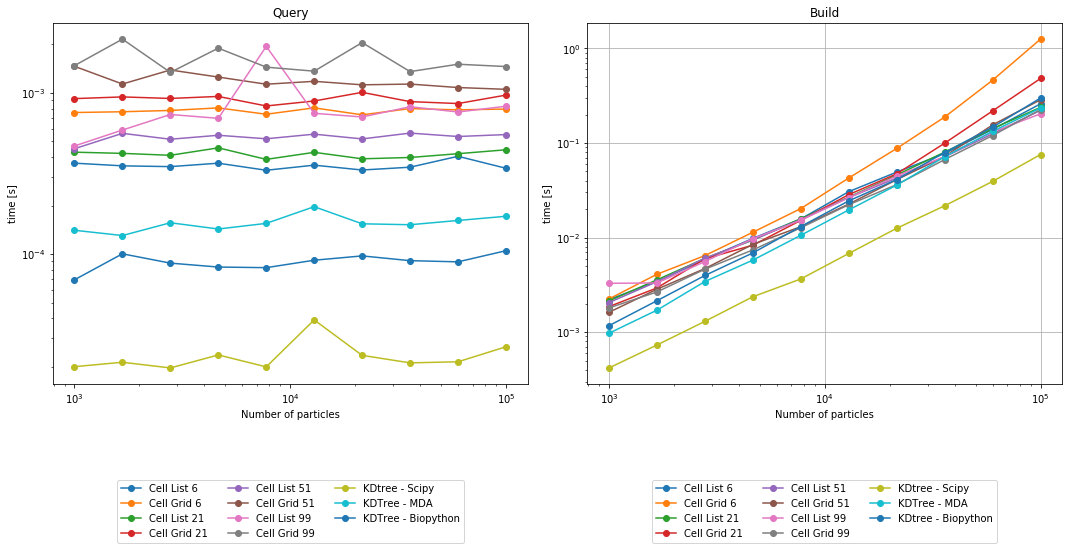

In [20]:
#Visualization
fig, axes = plt.subplots(ncols=2, figsize=(15,8))

for indx, val in enumerate(cellsize):
    ax = axes[0]
    ax.plot(res['N'], res['cl'+str(res['percell'][indx])], 'o-', label='Cell List '+str(res['percell'][indx]))
    ax.plot(res['N'], res['cg'+str(res['percell'][indx])], 'o-', label='Cell Grid '+str(res['percell'][indx]))
    
    ax.set(xlabel='Number of particles', ylabel='time [s]', xscale = 'log', yscale='log', title='Query')
    

    ax = axes[1]
    ax.plot(res['N'], res_build['cl'+str(res['percell'][indx])], 'o-', label='Cell List '+str(res['percell'][indx]))
    ax.plot(res['N'], res_build['cg'+str(res['percell'][indx])], 'o-', label='Cell Grid '+str(res['percell'][indx]))
    
    ax.set(xlabel='Number of particles', ylabel='time [s]', xscale = 'log',  yscale='log', title='Build')
    ax.grid(True)
axes[0].plot(res['N'], res['sckd'], 'o-', label='KDtree - Scipy')
axes[0].plot(res['N'], res['kdmda'], 'o-', label='KDTree - MDA')
axes[0].plot(res['N'], res['bkd'], 'o-', label='KDTree - Biopython')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True)
axes[1].plot(res['N'], res_build['sckd'], 'o-', label='KDtree - Scipy')
axes[1].plot(res['N'], res_build['kdmda'], 'o-', label='KDTree - MDA')
axes[1].plot(res['N'], res_build['bkd'], 'o-', label='KDtree - Biopython')
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True)
fig.tight_layout()

Different numbers in the legend denote the number of particles per cell. 
Few observations can be made from the figure.
* Build time for KDtree as well as celllist scales with number of particles and constant density is not a control parameter. However, the build times for cell-list has a smaller slope compared to KDtree.
* Query time of Cell-list as well as KDtree is constant for constant density. Furthermore, the single query time is dependent on the cellsize, such that larger cell sizes take more amount of time due to more number of particles per cell. 
* For these cases, kdtree is always advantageous as opposed to cell-list in terms of query time whereas, building time for celllist is comparitively lower for very large number of particles. Since, build time is more significant of the two, cell-list becomes advantageous for single query for large datasets.  
* Grid size equivalent to cutoff distance is the optimized cell size in cell-list algorithm. The smallest value in the legend correspond to the smallest cellsize (cutoff distance) and so on.  
* Non periodic Scipy implementation of KDtree takes the least amount of time in all of the methods followed by Biopython and  Periodic KDtree in MDAnalysis. Interestingly, cKDTree of scipy is faster than Biopython. 
* It should be mentioned the brute force method also scales linearly with the number of particles. Therefore, all these methods become advantageous for multiple queries.

## Cutoff Radius

We have established that lowest number of particles per unit cell i.e. grid size equivalent to the cutoff radius is optimum for single queries. Lets see the variation of cutoff radius for fixed radius neighbour search for different methods.

In [51]:
#Initialization
searchradius = np.linspace(4.0, 9.0, num = 6)
N = np.logspace(3, 5, num = 10)
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
pos = BOX[:3]/2

In [52]:
res_build3 = defaultdict(list)
res_query3 = defaultdict(list)
flag = 0
for n in tqdm_notebook(np.unique(N).astype(int)):
    coords = get_coords(_check_box(box), n)
    res_query3['N'].append(n)   
    for r in tqdm_notebook(np.unique(searchradius).astype(float)):
        if flag == 0:
            res_query3['radius'].append(int(r))
        ##Build Time (Only cell-list structure)
        res_cg = %timeit -o -q cellgrid_build(box, coords, r)
        res_cl = %timeit -o -q CellList(box, coords, r)
        
        res_build3['cg'+'.'+str(int(r))].append(res_cg.average)
        res_build3['cl'+'.'+str(int(r))].append(res_cl.average)
        
        cg = cellgrid_build(box, coords, r)
        cl = CellList(box, coords, r)
        
        ## Execution Time
        res_cl  = %timeit -o -q cl.search(pos, r)
        res_cg = %timeit -o -q cellgrid_query(cg, pos, r)
        
        res_query3['cl'+'.'+str(int(r))].append(res_cl.average)
        res_query3['cg'+'.'+str(int(r))].append(res_cg.average)
        
        
        #MDAnalysis - KDtree
        pkdt = kdtree_build(BOX, coords)
        res_kdmda = %timeit -o -q kdtree_query(pkdt, coords, pos, r)
        res_query3['kdmda'+'.'+str(int(r))].append(res_kdmda.average)
        
        # Scipy - KDTree
        sckd = scipy_build(box, coords)
        res_sckd = %timeit -o -q scipy_query(sckd, coords, pos, r)
        res_query3['sckd'+'.'+str(int(r))].append(res_sckd.average)
        
        # BioPython - KDTree
        bkd = biopython_build(box, coords)
        res_bkd = %timeit -o -q biopython_query(bkd, coords, pos, r)
        res_query3['bkd'+'.'+str(int(r))].append(res_bkd.average)
    flag += 1

In [63]:
res_query3

defaultdict(list,
            {'N': [1000,
              1668,
              2782,
              4641,
              7742,
              12915,
              21544,
              35938,
              59948,
              100000],
             'radius': [4,
              5,
              6,
              7,
              8,
              9,
              4,
              5,
              6,
              7,
              8,
              9,
              4,
              5,
              6,
              7,
              8,
              9,
              4,
              5,
              6,
              7,
              8,
              9,
              4,
              5,
              6,
              7,
              8,
              9,
              4,
              5,
              6,
              7,
              8,
              9,
              4,
              5,
              6,
              7,
              8,
              9,
              4,
              5,
            

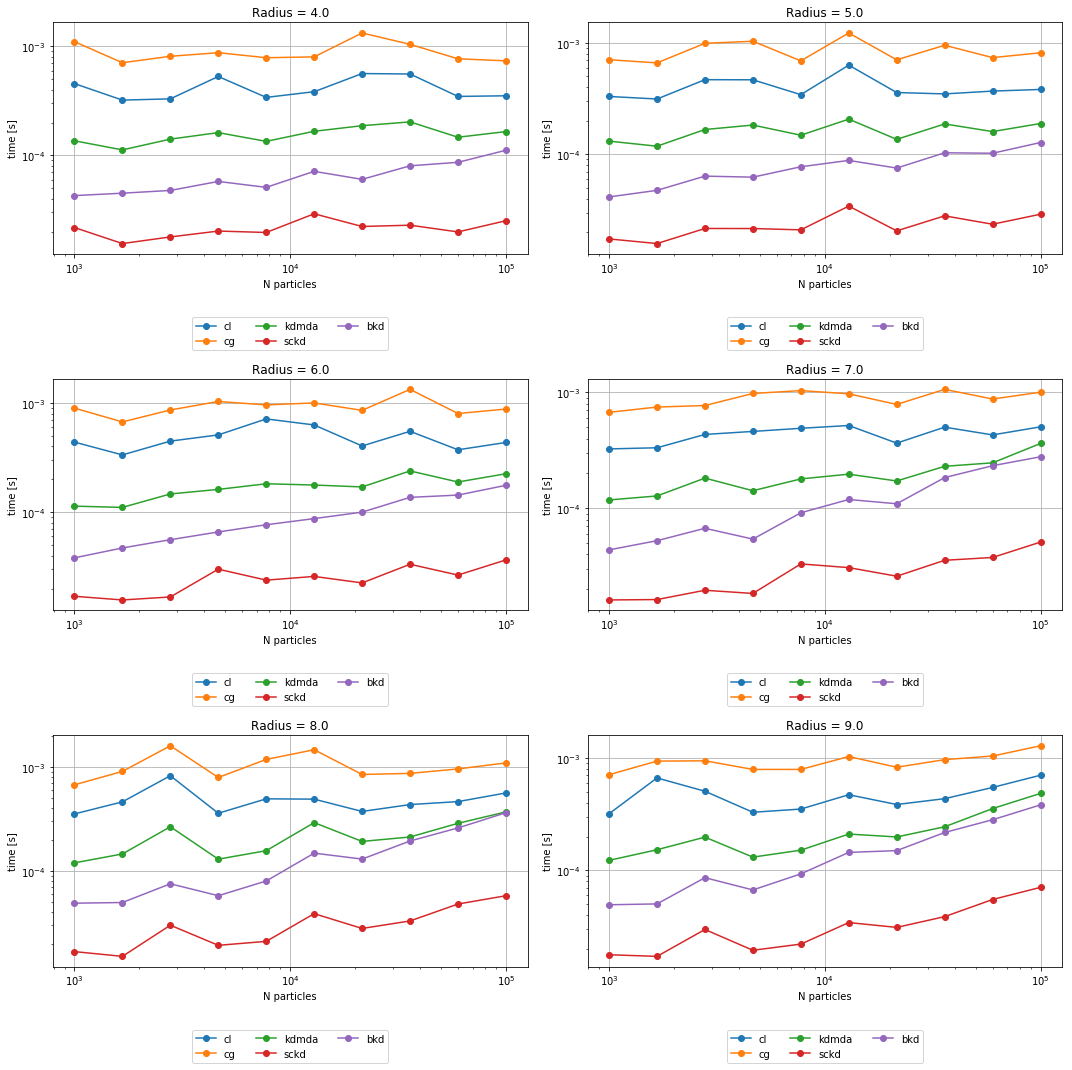

In [67]:
#Visualization - Query Time with number of particles for different radius
fig, axes = plt.subplots(nrows= len(searchradius)//2, ncols=2, figsize=(15,15))
for index,val in enumerate(searchradius):
    i,j = index // 2, index % 2
    for method in ['cl', 'cg', 'kdmda', 'sckd', 'bkd']:
        string = method +'.'+ str(int(val))
        axes[i,j].plot(res_query3['N'], res_query3[string], 'o-', label= '{}'.format(method))
        axes[i,j].set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Radius = {}'.format(val))
        axes[i,j].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True)
        axes[i,j].grid(True)
#fig, axes = plt.subplots(ncols=2, figsize=(15,8))
    ##Build
    #for method in ['cl, cg']:
    #    string = method +'.'+ str(int(r))
    #    axes[1].plot(res_query3['N'], res_build3[string], 'o-', label= '{}-Radius = {}'.format(method, str(r)))
    #    axes[1].set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Build')
    #    axes[1].legend()
    #    axes[1].grid(True)
fig.tight_layout()

For a single point query, it is observed that the majority of the time is spent in building the data structure. For large number of particles, the cell list algorithm works better in comparison to KDtree data structure (MDAnalysis) and cell-list data structure as implemented in CellGrid package. The time consumption follows a similar trend with increase in cutoff radius. 